# Testing the idea of an "apodized" (smoothed) cut

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt
from scipy import special, signal, interpolate

from pypower import BaseMatrix
from pycorr import TwoPointCounter

sys.path.append('../bin')
from desi_file_manager import DESIFileName

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plt.rcParams["figure.autolayout"] = False
plots_dir = '../../plots/'

### Global parameters

In [2]:
# official desi ('desi') or locally ('local') generated window/pk
source = 'desi'

# mocks/version
version = 'v4_1' # one of 'first', 'second' if source == 'local' or 'v2', 'v3' if source == 'desi'

# tracer
tracer = 'ELG_LOPnotqso'
region = 'SGC'
completeness = 'complete'
zrange = (1.1, 1.6)

# multipoles
ells = (0, 2, 4)
ktmax = 0.5
krange = (0., 0.5, 0.005)

# cut
thetacut = 0.05

## Collision window

In [3]:
def get_dd_mock(data_dir, tracer, region, zrange, space='theta', return_rr=False, flavour='complete', weight='WEIGHT'):
    if space=='theta':
        fn_dd = 'ddcounts_theta_mock0_{}_{}_{}_{:.1f}_{:.1f}_{}thetamax10.npy'.format(tracer, flavour, region, zrange[0], zrange[1], (weight+'_') if weight is not None else '')
    if space=='rppi':
        fn_dd = 'ddcounts_rppi_mock0_{}_{}_{}_{:.1f}_{:.1f}_{}rpmax10.npy'.format(tracer, flavour, region, zrange[0], zrange[1], (weight+'_') if weight is not None else '')        
    dd_counter = TwoPointCounter.load(os.path.join(data_dir, fn_dd))
    
    if space=='theta':
        counts = dd_counter.wcounts/dd_counter.wnorm
    if space=='rppi':
        counts = np.sum(dd_counter.rebin((5, 1)).wcounts, axis=1)/dd_counter.wnorm
    x = dd_counter.sepavg()

    if return_rr:
        if space=='theta':
            fn_rr = 'rrcounts_theta_mock0_{}_{}_{}_{:.1f}_{:.1f}_{}thetamax10.npy'.format(tracer, flavour, region, zrange[0], zrange[1], (weight+'_') if weight is not None else '')
        if space=='rppi':
            fn_rr = 'rrcounts_rppi_mock0_{}_{}_{}_{:.1f}_{:.1f}_{}rpmax10.npy'.format(tracer, flavour, region, zrange[0], zrange[1], (weight+'_') if weight is not None else '')
        rr_counter = TwoPointCounter.load(os.path.join(data_dir, fn_rr))
        if space=='theta':
            rrcounts = rr_counter.wcounts/rr_counter.wnorm
        if space=='rppi':
            rrcounts = np.sum(rr_counter.rebin((5, 1)).wcounts, axis=1)/rr_counter.wnorm
            
        return x, counts, rrcounts
            
    return x, counts

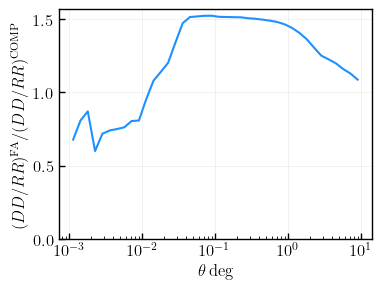

In [4]:
rr = False

fig, axes = plt.subplots(1, 1, figsize=(4, 3), sharey=True)

data_dir = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/v4_1/paircounts/'
theta, w_altmtl = get_dd_mock(data_dir, tracer=tracer, region=region, zrange=(1.1, 1.6), space='theta', return_rr=rr, flavour='altmtl')
theta, w_complete = get_dd_mock(data_dir, tracer=tracer[:7], region=region, zrange=(1.1, 1.6), space='theta', return_rr=rr, flavour='complete')

if rr:
    w_complete /= rr_complete
    w_altmtl /= rr_altmtl
    
w_theta = w_altmtl/w_complete

axes.semilogx(theta, w_theta)

#axes.axvline(0.05, ls=':', color='black')
axes.set_ylim(ymin=0)
axes.set_xlabel(r'$\theta \deg$')

axes.set_ylabel(r'$(DD/RR)^{\mathrm{FA}} / (DD/RR)^{\mathrm{COMP}}$')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

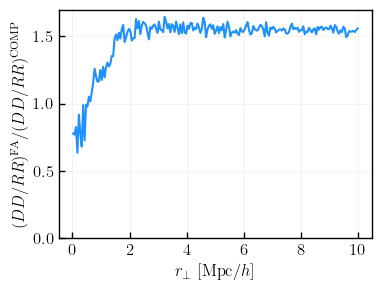

In [5]:
rr = False

fig, axes = plt.subplots(1, 1, figsize=(4, 3), sharey=True)

data_dir = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/v4_1/paircounts/'
rp, w_altmtl, rr_altmtl = get_dd_mock(data_dir, tracer=tracer, region=region, zrange=(1.1, 1.6), space='rppi', return_rr=True, flavour='altmtl')
rp, w_complete, rr_complete = get_dd_mock(data_dir, tracer=tracer[:7], region=region, zrange=(1.1, 1.6), space='rppi', return_rr=True, flavour='complete')

if rr:
    w_complete /= rr_complete
    w_altmtl /= rr_altmtl
    
w_rp = w_altmtl/w_complete

axes.plot(rp, w_rp)

#axes.axvline(0.05, ls=':', color='black')
axes.set_ylim(ymin=0)
axes.set_xlabel(r'$r_{\perp} \; [\mathrm{Mpc}/h]$')

axes.set_ylabel(r'$(DD/RR)^{\mathrm{FA}} / (DD/RR)^{\mathrm{COMP}}$')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

In [6]:
from scipy.interpolate import interp1d
w_rp_interp = interp1d(rp, w_rp)

from cosmoprimo import fiducial
cosmo = fiducial.DESI()
d = cosmo.comoving_angular_distance(1.05)

In [7]:
rp_eq = theta*np.pi/180*d
mask = rp_eq < np.max(rp)

In [8]:
0.05*d/180*np.pi

2.0721275168077002

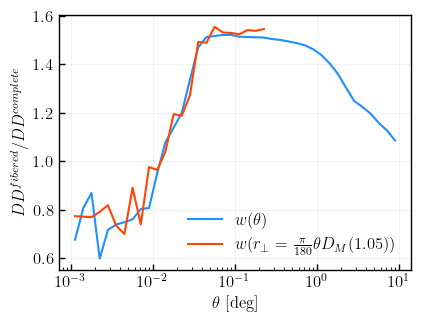

In [9]:
plt.figure(figsize=(4, 3))
plt.semilogx(theta, w_theta, label=r'$w(\theta)$')
plt.semilogx(theta[mask], w_rp_interp(rp_eq[mask]), label=r'$w(r_{\perp} = \frac{\pi}{180} \theta D_{M}(1.05))$')
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel(r'$DD^{fibered}/DD^{complete}$')
plt.legend()
plt.show()

## Configuration space

In [10]:
rpcut = thetacut*d/180*np.pi

#def apodization(rp2D, rpzero, window='tukey', rpcut=rpcut, **kwargs):
#    rp = np.linspace(0, 35, 1000)
#    res = np.zeros_like(rp)
#    if window == 'tukey':
#        kwargs['alpha'] = 1-rpcut/rpzero
#    if window == 'tophat':
#        res[rp < rpzero] = 1
#    else:
#        window_function =  getattr(signal.windows, window)
#        res[rp < rpzero] = window_function(M=2*len(rp[rp < rpzero]), **kwargs)[len(rp[rp < rpzero]):]
#    return 1-interpolate.interp1d(rp, res, bounds_error=False, fill_value=0)(rp2D)

def apodization(rp2D, rpzero, window='tukey', rpcut=rpcut, **kwargs):
    rp = np.linspace(0, 35, 1000)
    res = np.zeros_like(rp)
    if window == 'tukey':
        res = 1/2 * (1 + np.cos(np.pi * (rpzero - rp)/(rpzero - rpcut)))
        res[rp < rpcut] = 0
        res[rp > rpzero] = 1
    if window == 'tophat':
        res[rp < rpcut] = 0
        res[rp > rpzero] = 1
    return interpolate.interp1d(rp, res, bounds_error=False, fill_value=1)(rp2D)

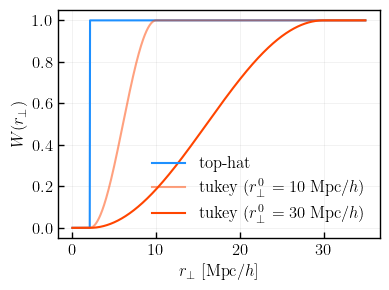

In [11]:
rp = np.linspace(0, 35, 1000)

rpzeros = [10, 30]

plt.figure(figsize=(4, 3))

ax = plt.gca()

ax.plot(rp, rp >= rpcut, label=r'top-hat', color='C0')

for i, rpzero in enumerate(rpzeros):
    tukey_corr = apodization(rp, rpzero, window='tukey', rpcut=rpcut)
    ax.plot(rp, tukey_corr, label=r'tukey ($r_{{\perp}}^0 = {} \; \mathrm{{Mpc}}/h$)'.format(rpzero), color='C1', alpha=0.5+i/2)
#tukey_corr = apodization(theta, 0.07, window='tukey', thetacut=0.04)
#ax.plot(theta, tukey_corr, label=r'tukey ($\theta_1 = {} \; \deg$, $\theta_0 = {} \; \deg$)'.format(0.03, 0.07), color='C1', ls='--')

ax.set_xlabel(r'$r_{{\perp}} \; [\mathrm{{Mpc}}/h]$')
ax.set_ylabel(r'$W(r_{{\perp}})$')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'rpcut_apodization_tukey.pdf'), dpi=300)
plt.show()

In [12]:
def apodize(wreal, rpzero=np.inf, window='tukey', rpcut=None):
    new = wreal.deepcopy()
    mu = np.linspace(0, 1, 2000)

    for iprojout, projout in enumerate(wreal.projs):
        new.corr[iprojout][...] = 0.
        for iprojin, projin in enumerate(wreal.projs):
            tmp = 2 * (2 * projout.ell + 1.) / 2. * np.trapz(apodization(wreal.sep[:, None] * np.sqrt(1 - mu**2), rpzero=rpzero, window=window, rpcut=rpcut) * special.legendre(projout.ell)(mu) * special.legendre(projin.ell)(mu), x=mu)
            #print(projin.ell, projout.ell, np.sum(tmp))
            new.corr[iprojout] += tmp * wreal.corr[iprojin]

    return new

In [13]:
from pypower import PowerSpectrumMultipoles, PowerSpectrumSmoothWindow

fn = DESIFileName()
fn.set_default_config(version=version, tracer=tracer, region=region, baseline=False, weighting='_default_FKP_lin', nran=18, cellsize=6, boxsize=9000)
fn.set_default_config(completeness=True, version=version).update(zrange=zrange)
power_fn = fn.get_path()
power = PowerSpectrumMultipoles.load(power_fn)

window_fn = fn.get_path(ftype='window_smooth', realization='merged', thetacut=thetacut, boxscale={})
window = PowerSpectrumSmoothWindow.concatenate_x(*[PowerSpectrumSmoothWindow.load(window_fn.format(int(boxscale))) for boxscale in (1, 5, 20)], frac_nyq=0.9)
#window = PowerSpectrumSmoothWindow.load(os.path.join(data_dir, 'windows/window_mock{:d}_{}_{}{}.npy'.format(0, tracer, completeness, region)))

In [14]:
window_nocut = window.copy()
window_nocut.corr_direct_nonorm = 0

In [15]:
sep = np.geomspace(1e-3, 4e3, 2048)
window_real_thetacut = window.to_real(sep=sep)
window_real_nocut = window_nocut.to_real(sep=sep)

In [16]:
window_real_rpcut = apodize(window_real_nocut, rpzero=rpcut, window='tophat', rpcut=rpcut)

In [17]:
from pypower import PowerSpectrumSmoothWindowMatrix

sep = np.geomspace(1e-4, 4e3, 1024*16)
wm_nocut = PowerSpectrumSmoothWindowMatrix(power.k, projsin=(0, 2, 4), projsout=(0, 2, 4), weightsout=power.nmodes, window=window_real_nocut, sep=sep)
wm_thetacut = PowerSpectrumSmoothWindowMatrix(power.k, projsin=(0, 2, 4), projsout=(0, 2, 4), weightsout=power.nmodes, window=window_real_thetacut, sep=sep)
wm_rpcut = PowerSpectrumSmoothWindowMatrix(power.k, projsin=(0, 2, 4), projsout=(0, 2, 4), weightsout=power.nmodes, window=window_real_rpcut, sep=sep)

In [18]:
window_real_apodized_rpcut = apodize(window_real_nocut, rpzero=3, window='tukey', rpcut=rpcut)
wm_apodized_rpcut = PowerSpectrumSmoothWindowMatrix(power.k, projsin=(0, 2, 4), projsout=(0, 2, 4), weightsout=power.nmodes, window=window_real_apodized_rpcut, sep=sep)

In [19]:
window_real_apodized10_rpcut = apodize(window_real_nocut, rpzero=10, window='tukey', rpcut=rpcut)
wm_apodized10_rpcut = PowerSpectrumSmoothWindowMatrix(power.k, projsin=(0, 2, 4), projsout=(0, 2, 4), weightsout=power.nmodes, window=window_real_apodized10_rpcut, sep=sep)

In [20]:
window_real_apodized30_rpcut = apodize(window_real_nocut, rpzero=30, window='tukey', rpcut=rpcut)
wm_apodized30_rpcut = PowerSpectrumSmoothWindowMatrix(power.k, projsin=(0, 2, 4), projsout=(0, 2, 4), weightsout=power.nmodes, window=window_real_apodized30_rpcut, sep=sep)

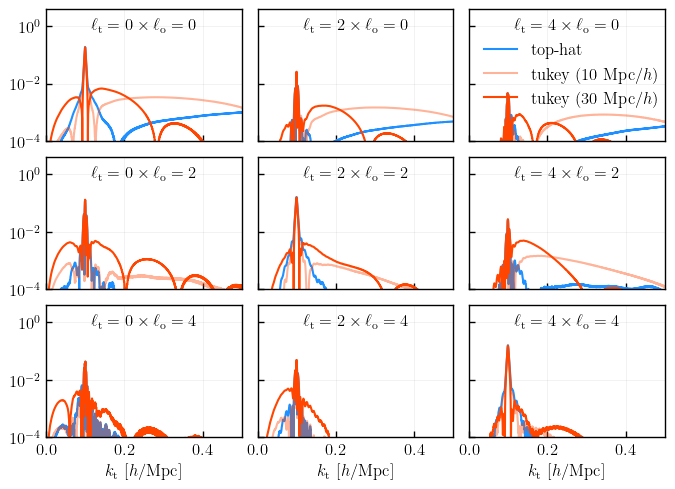

In [21]:
fig, lax = plt.subplots(len(ells), len(ells), sharex=True, sharey=True, figsize=(7, 5))

kobs = 0.1

indexout = np.abs(wm_nocut.xout[0] - kobs).argmin()

for iin, ellin in enumerate(ells):
    for iout, ellout in enumerate(ells):
        ax = lax[iout][iin]
        norm = wm_nocut.xin[iin]
        #ax.semilogy(wm_nocut.xin[iin], np.abs(wm_nocut.unpacked()[iin][iout][:, indexout] / norm), color='C0', ls=':', label=r'no cut' if iin==2 else '', alpha=0.2)
        ax.semilogy(wm_rpcut.xin[iin], np.abs(wm_rpcut.unpacked()[iin][iout][:, indexout] / norm), color='C0', label=r'top-hat' if iin==2 else '')
        #ax.semilogy(wm_apodized_rpcut.xin[iin], np.abs(wm_apodized_rpcut.unpacked()[iin][iout][:, indexout] / norm), color='C1', label=r'tukey (3 Mpc/$h$)' if iin==2 else '', alpha=0.4)
        ax.semilogy(wm_apodized10_rpcut.xin[iin], np.abs(wm_apodized10_rpcut.unpacked()[iin][iout][:, indexout] / norm), color='C1', label=r'tukey (10 Mpc/$h$)' if iin==2 else '', alpha=0.4)
        ax.semilogy(wm_apodized30_rpcut.xin[iin], np.abs(wm_apodized30_rpcut.unpacked()[iin][iout][:, indexout] / norm), color='C1', label=r'tukey (30 Mpc/$h$)' if iin==2 else '', alpha=1)
        text = r'$\ell_{{\mathrm{{t}}}} = {:d} \times \ell_{{\mathrm{{o}}}} = {:d}$'.format(ellin, ellout)
        ax.set_xlim((0, 0.5))
        xlim = ax.get_xlim()
        ax.text((xlim[0]+xlim[1])/2., 2, text, horizontalalignment='center', verticalalignment='top', color='black', fontsize=12)
        ax.set_ylim((1e-4, 4))
        if iout == len(ells) - 1: ax.set_xlabel(r'$k_{\mathrm{t}}$ [$h/\mathrm{Mpc}$]')
lax[0][2].legend(loc='center left')

fig.tight_layout()
fig.subplots_adjust(wspace=0.08, hspace=0.12)
plt.savefig(os.path.join(plots_dir, version, 'wmatrix_rpcut_apodization_{}_{}_{}.pdf'.format(tracer, region, completeness)), dpi=300)
plt.show()